# Kaggle House Princing
 * EDA
 * Fill missing values
 * Standardize some feartures
 * Replace outliners
 * Deal with multicollinearity
 * Feature selection
 * Fit Models(NN, xgb, adaboost, randomforest)
 * Grid search cross validation

## Infile

In [1]:
#init
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from fancyimpute import KNN
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
path = 'D:/Download/house_price/train.csv'
test_path = 'D:/Download/house_price/test.csv'
train_x = pd.read_csv(path)
test = pd.read_csv(test_path)
print(train_x.shape,test.shape)
# print(train_x.columns)

C:\Users\Mozzie\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(1460, 81) (1459, 80)


## Split data

In [2]:
train_x = train_x.drop(train_x[(train_x['GrLivArea']>4000) & (train_x['SalePrice']<300000)].index)
train_y = train_x['SalePrice']
train_x.drop(columns=['Id','SalePrice'],inplace=True)
test.drop(columns=['Id'],inplace=True)
df = pd.concat([train_x,test],axis=0)
assert df.shape[0] == 2917
assert df.shape[1] == 79

In [3]:
num = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF',
       '2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',
       'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch',
       'ScreenPorch','PoolArea','MiscVal']
yr=['YearBuilt', 'YrSold', 'YearRemodAdd','GarageYrBlt']
ord_cat =['MSSubClass','LotShape','Utilities','LandSlope','OverallQual','OverallCond','Street','HouseStyle','ExterQual','ExterCond',
       'HeatingQC','GarageQual','GarageCond','BsmtQual','BsmtCond','KitchenQual','FireplaceQu','PoolQC']
cat = df.columns
cat = cat.drop(num).drop(yr).drop(ord_cat)
assert len(num)+len(yr)+len(ord_cat)+len(cat)==79

## Distribution

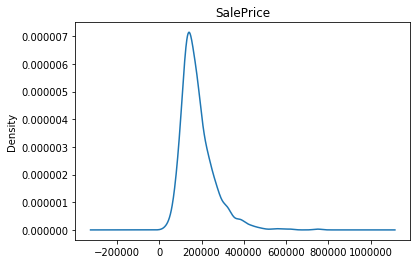

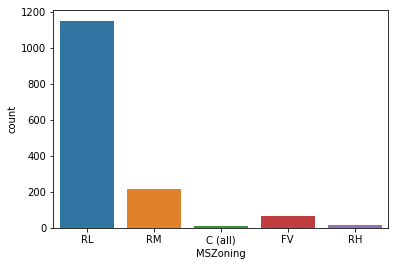

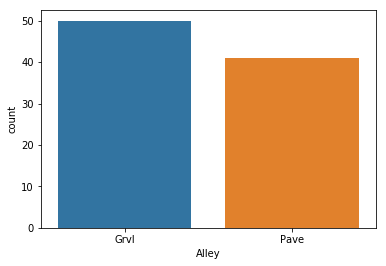

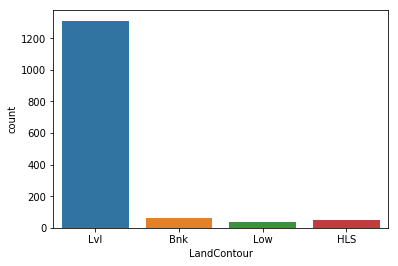

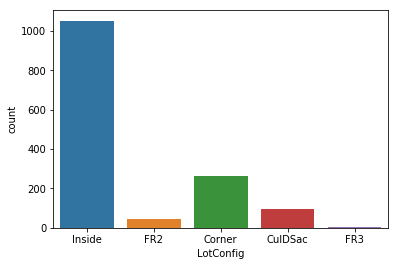

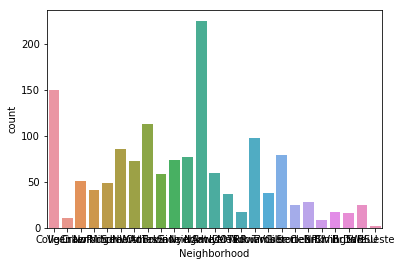

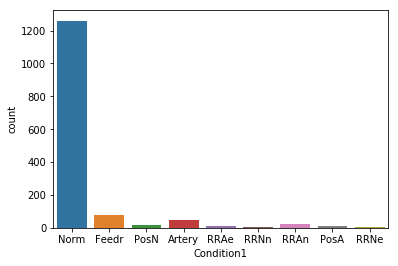

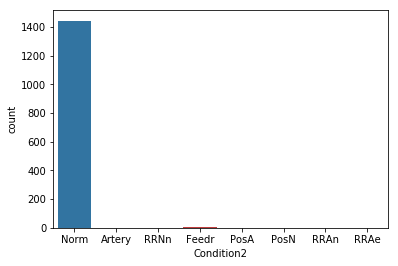

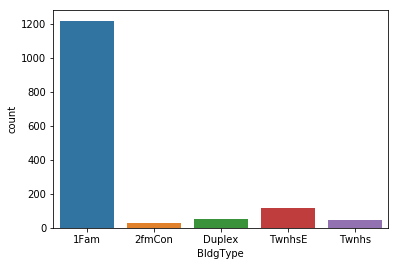

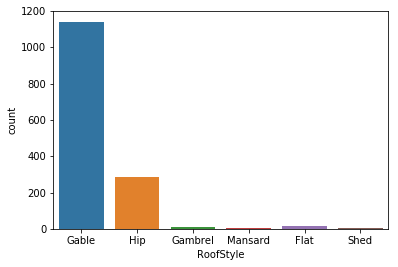

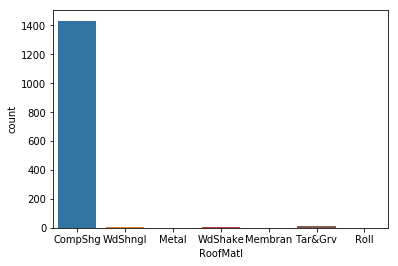

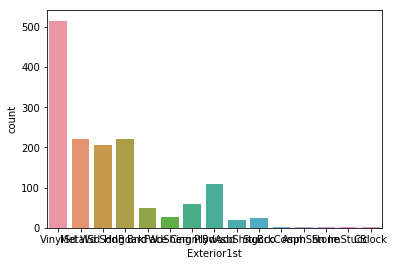

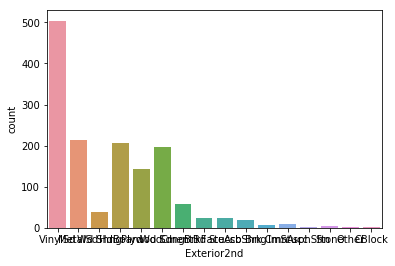

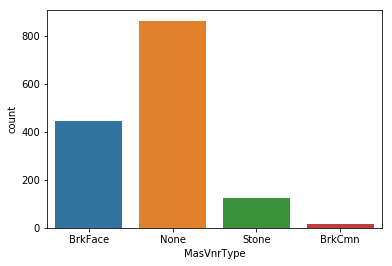

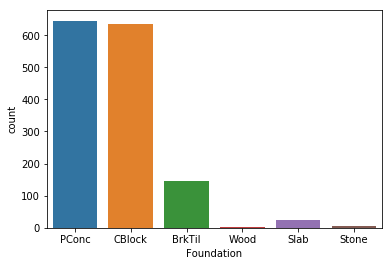

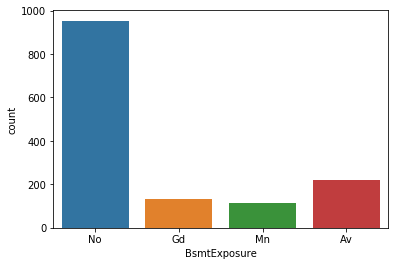

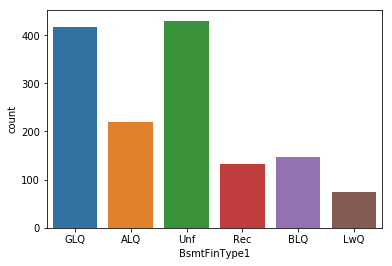

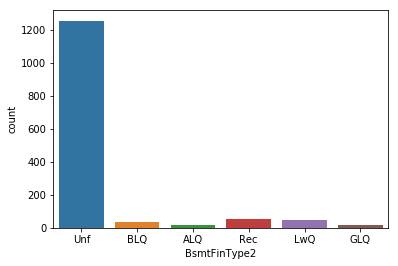

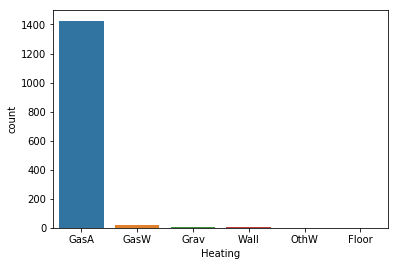

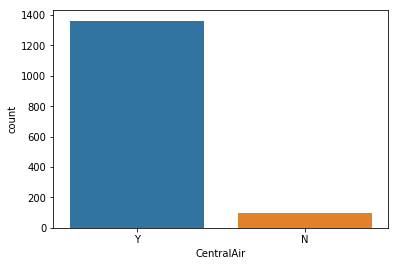

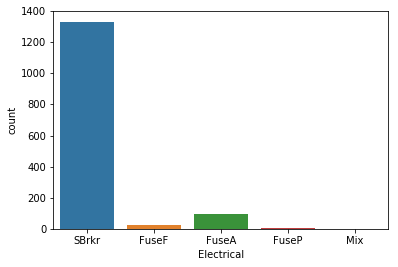

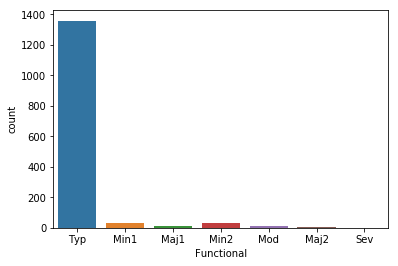

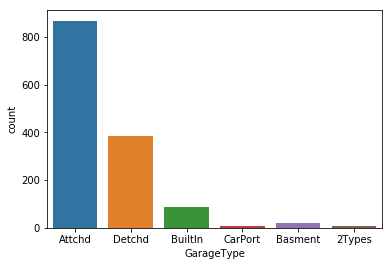

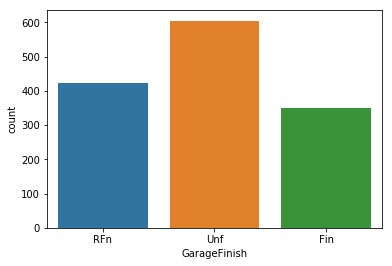

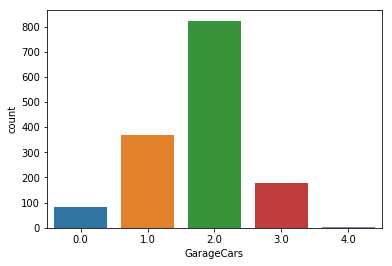

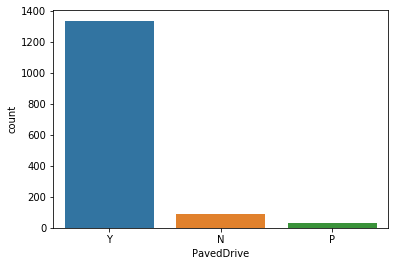

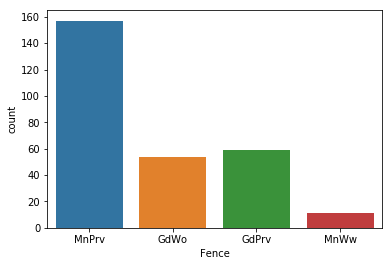

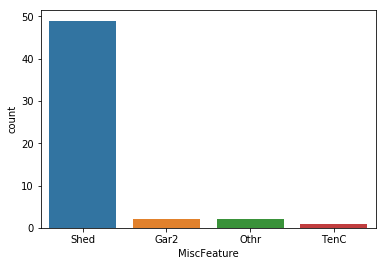

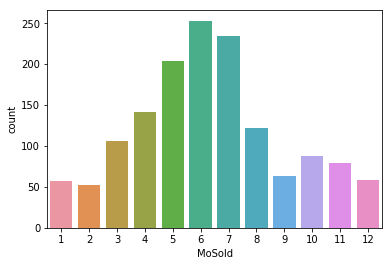

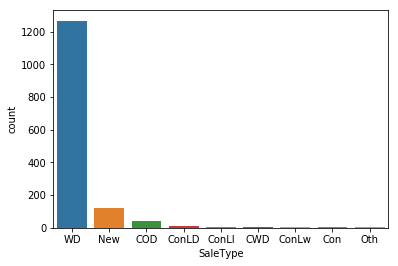

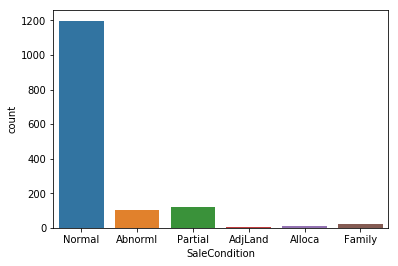

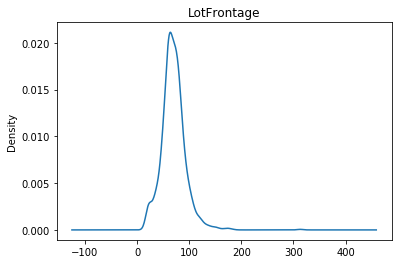

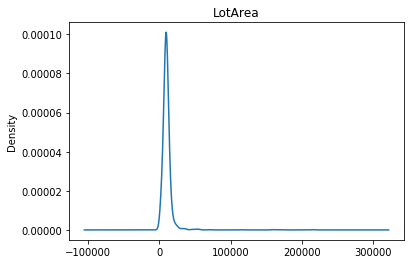

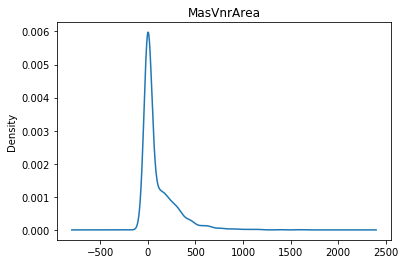

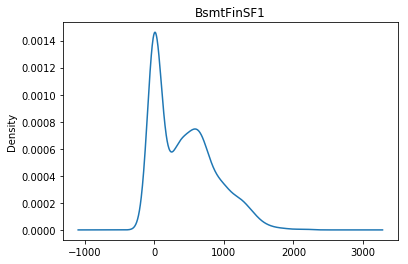

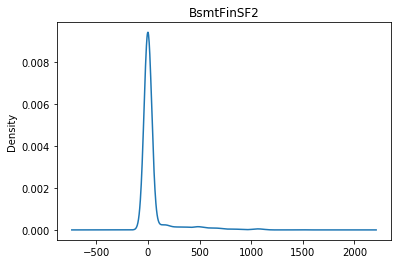

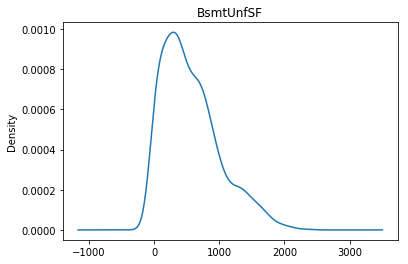

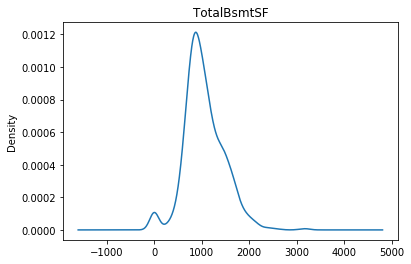

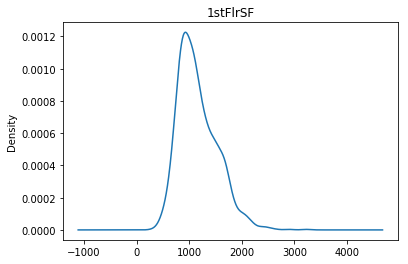

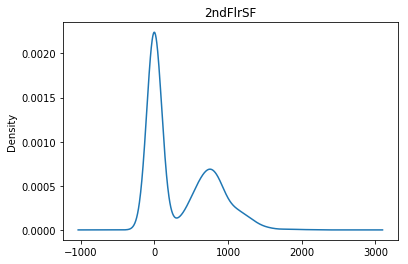

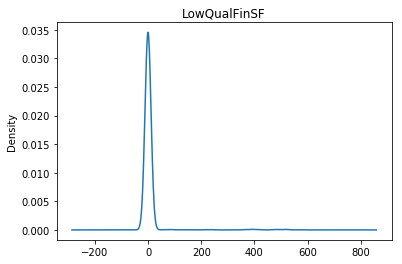

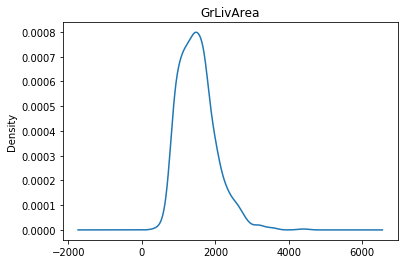

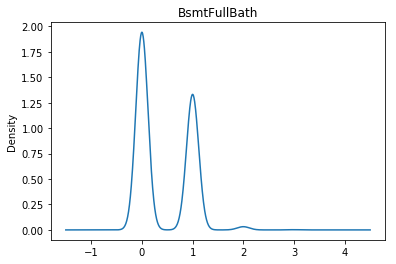

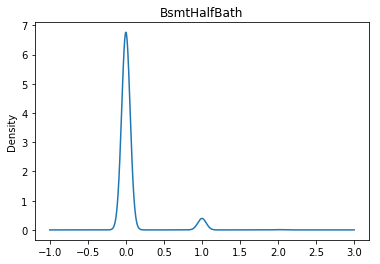

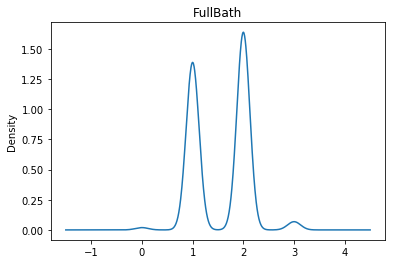

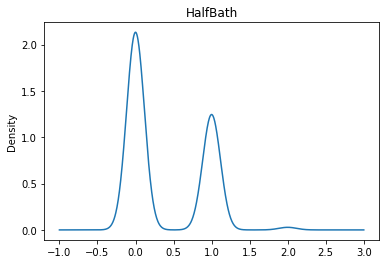

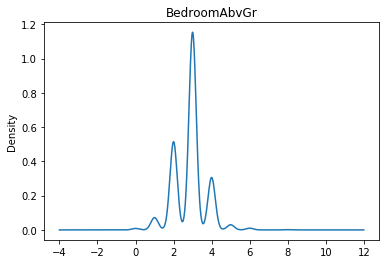

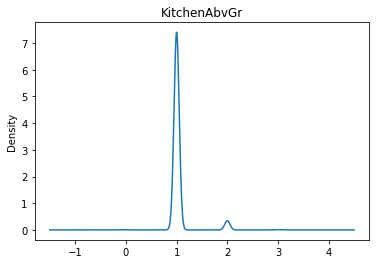

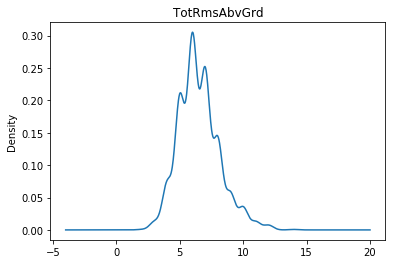

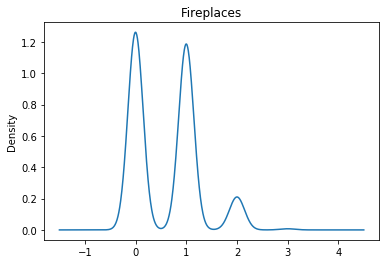

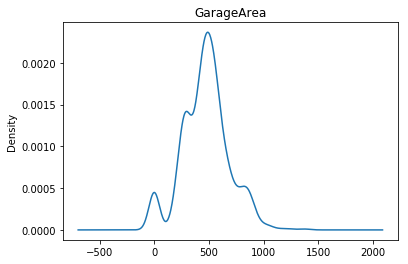

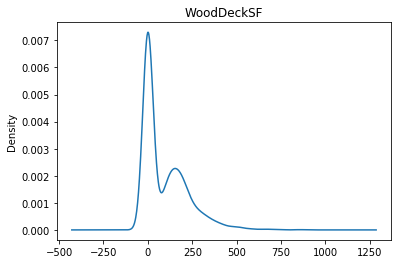

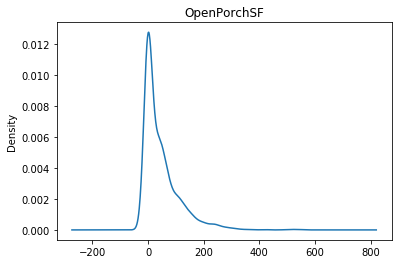

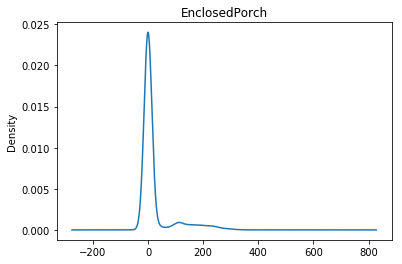

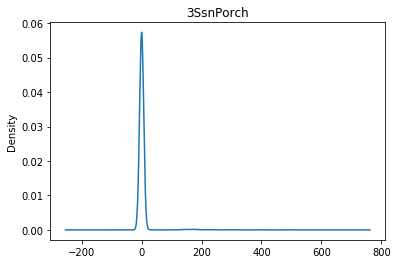

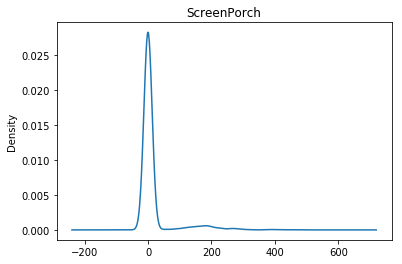

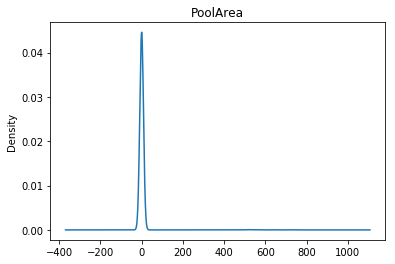

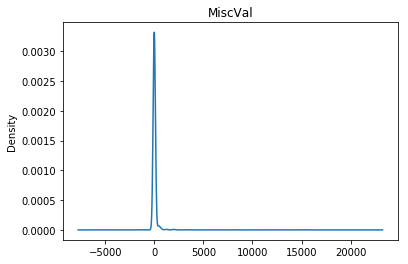

In [4]:
train_y.plot(kind='density',title='SalePrice')
plt.show()
for i in range(df[cat].shape[1]):
    sns.countplot(x=df[cat].columns[i], data=df.iloc[:1458,:])
    plt.show()
for i in df[num].columns:
    df.iloc[:1458,:][i].plot(kind='density',title=i)
    plt.show()
df['GrLivArea'] = np.log(df['GrLivArea'])

## FillNA

In [5]:
#df.isna().sum()[df.isna().sum()>0].index#.map(lambda x:x in num)

# garg = ['GarageFinish','GarageYrBlt','GarageCars','GarageArea','GarageQual','GarageCond']
# df[garg].head()
# bsmt = ['BsmtFinType1', 'BsmtFinType2', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF1']
fillNA = ('GarageType','GarageYrBlt', 'GarageFinish','GarageQual','GarageCond','BsmtQual','BsmtCond','BsmtFinType1','BsmtFinType2','PoolQC','Alley')
# df['BsmtExposure'].unique()
fillmode = ('MSZoning', 'Utilities','Exterior1st','Exterior2nd','KitchenQual','Electrical','Functional','Fence','MiscFeature','SaleType')
df[['MasVnrType']]=df['MasVnrType'].fillna(value='None')
df[['BsmtExposure']]=df['BsmtExposure'].fillna(value='No')
for i in fillNA:
    df[[i]]=df[i].fillna(value='NA')
for i in fillmode:
    df[[i]]=df[i].fillna(value=df[i].mode()[0])
for i in range(df.shape[0]):
    if df['GarageFinish'].iloc[i] == 'NA':
        df['GarageYrBlt'].iloc[i] = 0
        df['GarageCars'].iloc[i] = 0
        df['GarageArea'].iloc[i] = 0
        df['GarageQual'].iloc[i] = 'NA'
        df['GarageCond'].iloc[i] = 'NA'
    if df['FireplaceQu'].iloc[i] == 'NA':
        df['Fireplaces'].iloc[i] = 0
    if df['Fireplaces'].iloc[i] == 0:
        df['FireplaceQu'].iloc[i] = 'NA'
    if df['BsmtFinType1'].iloc[i] == 'NA' and df['BsmtFinType2'].iloc[i] == 'NA':
        df['TotalBsmtSF'].iloc[i] = 0
        df['BsmtUnfSF'].iloc[i] = 0
        df['BsmtFinSF1'].iloc[i] = 0
        df['BsmtExposure'].iloc[i] = 'No'
    if df['PoolQC'].iloc[i] == 'NA':
        df['PoolArea'].iloc[i] = 0
    if df['PoolArea'].iloc[i] == 0:
        df['PoolQC'].iloc[i] = 'NA'
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))


for i in ('MasVnrArea', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath'):
    df[[i]]=df[i].fillna(value=0)
assert df.isna().sum().sum()==0

C:\Users\Mozzie\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## Factorize

In [7]:
for i in cat:
    df[i]=pd.factorize(df[i])[0]
# for i in cat:
#     print(i,df[i].unique())

In [8]:
for i in ord_cat:
    df[i]=pd.factorize(df[i])[0]
# df['MSSubClass'] = np.floor(df['MSSubClass']/5).transform(lambda x: min(x,2))
# df['OverallQual']=np.floor(df['OverallQual']/2)
# df['OverallCond']=np.floor(df['OverallCond']/2)
# for i in ord_cat:
#     print(i,df[i].unique())

# Skewness

In [9]:
from scipy.stats import norm, skew
# Check the skew of all numerical features
skewed_feats = df[num].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,20.563597
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101
BsmtHalfBath,3.929996


In [10]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
skewed_features = skewness.index

# df[skewed_features] = np.log1p(df[skewed_features])
from scipy.special import boxcox1p
lam = 0.15
for feat in skewed_features:
    df[feat] = boxcox1p(df[feat], lam)

There are 27 skewed numerical features to Box Cox transform


## Outliers

In [11]:
for col in num:
    scaler = StandardScaler()
    scaler.fit(df[[col]])
    ss = scaler.transform(df[[col]])
    maxv = ss.mean()+3*ss.std()
    minv = ss.mean()-3*ss.std()
    for i in range(len(ss)):
        if ss[i]<minv:
            ss[i] = minv
        if ss[i]>maxv:
            ss[i] = maxv
    df[col] = scaler.inverse_transform(ss)

# Save Point
### To tried out different feature selection, saving dataset and adjust it after is more efficient.

In [ ]:
#save point(2919, 79)
df.to_csv('D:/Download/house_price/sp3.csv',index=False)
train_y.to_csv('D:/Download/house_price/sp3_y.csv',index=False)

## Load Point

In [ ]:
#load point
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from fancyimpute import KNN
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
df = pd.read_csv('D:/Download/house_price/sp3.csv')
train_y = pd.read_csv('D:/Download/house_price/sp3_y.csv',header=None)
train_y=train_y[0]
num = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF',
       '2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',
       'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch',
       'ScreenPorch','PoolArea','MiscVal']
yr=['YearBuilt', 'YrSold', 'YearRemodAdd','GarageYrBlt']
ord_cat =['MSSubClass','LotShape','Utilities','LandSlope','OverallQual','OverallCond','Street','HouseStyle','ExterQual','ExterCond',
       'HeatingQC','GarageQual','GarageCond','BsmtQual','BsmtCond','KitchenQual','FireplaceQu','PoolQC']
cat = ['MSZoning', 'Alley', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'CentralAir',
       'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'GarageCars',
       'PavedDrive', 'Fence', 'MiscFeature', 'MoSold', 'SaleType',
       'SaleCondition']
assert df.shape[0]==2917
assert df.shape[1]==79
assert df.isna().sum().any()==False

## Standardize y

In [12]:
log_train_y = np.log1p(train_y)

## Dimention reduction
* check collinear feature pairs
* combine some features
* orginize list

In [13]:
df.drop(columns=['Utilities'],inplace=True)
ord_cat.remove('Utilities')
c = df.iloc[range(1458),:][num].corr()
c = c[abs(c)>0.6]
for i in range(c.shape[0]-1):
    for j in range(i+1):
        if c.iloc[i,j]<1:
            print(c.columns[i],c.columns[j],c.iloc[i,j])

LotArea LotFrontage 0.6733051340481158
BsmtFullBath BsmtFinSF1 0.6186900971210428
FullBath GrLivArea 0.6508549989423446
HalfBath 2ndFlrSF 0.6017132513474118
TotRmsAbvGrd GrLivArea 0.8274632677452445
TotRmsAbvGrd BedroomAbvGr 0.6764078353440005


In [14]:
def Polymerization(cols,new_name,data,n=1):
    pca = PCA(n_components=n)
    new_col = pca.fit_transform(data[cols])
    data.drop(columns=cols,inplace=True)
    data[new_name]=new_col
    return data

Big_ground = ['TotRmsAbvGrd', 'GrLivArea', 'BedroomAbvGr', 'FullBath']
Big_Lot = ['LotArea', 'LotFrontage']
df = Polymerization(Big_ground,'Big_ground',df)
df = Polymerization(Big_Lot,'Big_Lot',df)
garageQC = ['GarageCond', 'GarageQual']
bsmtQC = ['BsmtQual','BsmtCond']
exterQC = ['ExterQual','ExterCond']
df['garageQC'] = df[garageQC[0]]*df[garageQC[1]]
df['bsmtQC'] = df[bsmtQC[0]]*df[bsmtQC[1]]
df['exterQC'] = df[exterQC[0]]*df[exterQC[1]]
df.drop(columns=garageQC,inplace=True)
df.drop(columns=bsmtQC,inplace=True)
df.drop(columns=exterQC,inplace=True)

In [15]:
for i in Big_ground:
    num.remove(i)
for i in Big_Lot:
    num.remove(i)
num += ['Big_ground','Big_Lot']
ord_cat.remove('GarageCond')
ord_cat.remove('GarageQual')
ord_cat.remove('BsmtQual')
ord_cat.remove('BsmtCond')
ord_cat.remove('ExterQual')
ord_cat.remove('ExterCond')
ord_cat += ['garageQC','bsmtQC','exterQC']
# assert len(ord_cat) == 15

## Dimention Extension

In [16]:
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
num += ['TotalSF']
cor_table=pd.DataFrame()
tmp = []
tmpp =[]
for i in num:
    tmp += [i]
    tmpp += [train_y.corr(df.iloc[:1458,:][i])]
for i in ord_cat:
    tmp += [i]
    tmpp += [train_y.corr(df.iloc[:1458,:][i])]
cor_table['column']=tmp
cor_table['correlation']=tmpp
cor_table[abs(cor_table.correlation)>0.45].sort_values('correlation')

,column,correlation
21,Big_ground,-0.495882
13,GarageArea,0.468697
12,Fireplaces,0.480857
4,TotalBsmtSF,0.514401
5,1stFlrSF,0.604761


In [17]:
de_list = cor_table[abs(cor_table.correlation)>0.4].column
def extra_pow(col,df):
    newcol2=col+'2'
    newcol3=col+'3'
    df[newcol2] = df[col]*df[col]
    df[newcol3] = df[col]*df[col]*df[col]
for i in de_list:
    extra_pow(i,df)

## one-hot encoding
* Category 
* All year variables/ GarageYrBlt

In [18]:
# df = pd.get_dummies(df,columns=cat)
# df = pd.get_dummies(df,columns=['GarageYrBlt'])
# assert df.shape[1]==372

In [19]:
df = pd.get_dummies(df,columns=cat)
df = pd.get_dummies(df,columns=yr)
# assert df.shape[1] ==551
# assert df.shape[1] ==541

## Return train/test

In [20]:
train_x = df.iloc[:1458,:]
test = df.iloc[1458:,:]
train_x.shape,test.shape

((1458, 559), (1459, 559))

## Feature selection
* Standardize
* LassoCV

In [21]:
#standardlized
scaler = StandardScaler()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
test = scaler.transform(test)

In [34]:
lcv = LassoCV(cv=10,alphas=range(1000,8000,500),n_jobs=-1)
sfm = SelectFromModel(lcv, threshold=0.25)
sfm.fit(train_x, train_y)
train_x_reduced = sfm.transform(train_x)
test_reduced = sfm.transform(test)
train_x_reduced.shape,test_reduced.shape

((1458, 144), (1459, 144))

## Keras NN

In [36]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,regularizers,Dropout
from keras import optimizers
from keras.initializers import glorot_normal

In [37]:
# opt = optimizers.RMSprop(lr=0.001, rho=0.1, epsilon=None)
# opt = optimizers.SGD(nesterov=True,momentum=0.8,lr=0.0005)
model = Sequential()
model.add(Dense(512,input_dim=144,activation='relu',kernel_initializer=glorot_normal(seed=None)
                ,bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
for i in range(1):
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
model.add(Dense(1, activation='linear'))
model.compile(loss='mse',optimizer='adam',metrics=['mse'])
model.fit(x=train_x_reduced,y=log_train_y,validation_split=0.1, epochs=2000, verbose=1)
pred_y = model.predict(test_reduced)
pred_y = np.expm1(pred_y)
print(pred_y)

Train on 1312 samples, validate on 146 samples
Epoch 1/2000
1312/1312 [==============================] - 1s 539us/step - loss: 132.2352 - mean_squared_error: 132.0102 - val_loss: 116.5990 - val_mean_squared_error: 116.3735
Epoch 2/2000
1312/1312 [==============================] - 0s 168us/step - loss: 88.5488 - mean_squared_error: 88.3224 - val_loss: 76.0808 - val_mean_squared_error: 75.8527
Epoch 3/2000
1312/1312 [==============================] - 0s 165us/step - loss: 34.3215 - mean_squared_error: 34.0916 - val_loss: 28.8699 - val_mean_squared_error: 28.6381
Epoch 4/2000
1312/1312 [==============================] - 0s 189us/step - loss: 10.1333 - mean_squared_error: 9.8998 - val_loss: 4.9052 - val_mean_squared_error: 4.6701
Epoch 5/2000
1312/1312 [==============================] - 0s 157us/step - loss: 5.7874 - mean_squared_error: 5.5514 - val_loss: 3.6709 - val_mean_squared_error: 3.4345
Epoch 6/2000
1312/1312 [==============================] - 0s 155us/step - loss: 5.0258 - mean_sq

1312/1312 [==============================] - 0s 149us/step - loss: 0.1530 - mean_squared_error: 0.0300 - val_loss: 0.1470 - val_mean_squared_error: 0.0249
Epoch 98/2000
1312/1312 [==============================] - 0s 144us/step - loss: 0.1457 - mean_squared_error: 0.0244 - val_loss: 0.1413 - val_mean_squared_error: 0.0210
Epoch 99/2000
1312/1312 [==============================] - 0s 152us/step - loss: 0.1484 - mean_squared_error: 0.0290 - val_loss: 0.1408 - val_mean_squared_error: 0.0223
Epoch 100/2000
1312/1312 [==============================] - 0s 146us/step - loss: 0.1480 - mean_squared_error: 0.0303 - val_loss: 0.1379 - val_mean_squared_error: 0.0212
Epoch 101/2000
1312/1312 [==============================] - 0s 137us/step - loss: 0.1380 - mean_squared_error: 0.0221 - val_loss: 0.1348 - val_mean_squared_error: 0.0198
Epoch 102/2000
1312/1312 [==============================] - 0s 153us/step - loss: 0.1388 - mean_squared_error: 0.0248 - val_loss: 0.1321 - val_mean_squared_error: 0.01

1312/1312 [==============================] - 0s 153us/step - loss: 0.0249 - mean_squared_error: 0.0157 - val_loss: 0.0379 - val_mean_squared_error: 0.0289
Epoch 194/2000
1312/1312 [==============================] - 0s 170us/step - loss: 0.0332 - mean_squared_error: 0.0244 - val_loss: 0.0396 - val_mean_squared_error: 0.0310
Epoch 195/2000
1312/1312 [==============================] - 0s 161us/step - loss: 0.0260 - mean_squared_error: 0.0175 - val_loss: 0.0291 - val_mean_squared_error: 0.0207
Epoch 196/2000
1312/1312 [==============================] - 0s 166us/step - loss: 0.0322 - mean_squared_error: 0.0238 - val_loss: 0.0375 - val_mean_squared_error: 0.0291
Epoch 197/2000
1312/1312 [==============================] - 0s 158us/step - loss: 0.0270 - mean_squared_error: 0.0186 - val_loss: 0.0341 - val_mean_squared_error: 0.0257
Epoch 198/2000
1312/1312 [==============================] - 0s 157us/step - loss: 0.0351 - mean_squared_error: 0.0218 - val_loss: 0.0522 - val_mean_squared_error: 0.

1312/1312 [==============================] - 0s 159us/step - loss: 0.0292 - mean_squared_error: 0.0201 - val_loss: 0.0327 - val_mean_squared_error: 0.0224
Epoch 290/2000
1312/1312 [==============================] - 0s 181us/step - loss: 0.0290 - mean_squared_error: 0.0172 - val_loss: 0.0348 - val_mean_squared_error: 0.0228
Epoch 291/2000
1312/1312 [==============================] - 0s 181us/step - loss: 0.0264 - mean_squared_error: 0.0147 - val_loss: 0.0319 - val_mean_squared_error: 0.0207
Epoch 292/2000
1312/1312 [==============================] - 0s 171us/step - loss: 0.0248 - mean_squared_error: 0.0139 - val_loss: 0.0323 - val_mean_squared_error: 0.0217
Epoch 293/2000
1312/1312 [==============================] - 0s 156us/step - loss: 0.0284 - mean_squared_error: 0.0181 - val_loss: 0.0540 - val_mean_squared_error: 0.0439
Epoch 294/2000
1312/1312 [==============================] - 0s 142us/step - loss: 0.0286 - mean_squared_error: 0.0186 - val_loss: 0.0333 - val_mean_squared_error: 0.

1312/1312 [==============================] - 0s 163us/step - loss: 0.0217 - mean_squared_error: 0.0162 - val_loss: 0.0284 - val_mean_squared_error: 0.0229
Epoch 386/2000
1312/1312 [==============================] - 0s 150us/step - loss: 0.0190 - mean_squared_error: 0.0135 - val_loss: 0.0286 - val_mean_squared_error: 0.0220
Epoch 387/2000
1312/1312 [==============================] - 0s 145us/step - loss: 0.0201 - mean_squared_error: 0.0129 - val_loss: 0.0312 - val_mean_squared_error: 0.0242
Epoch 388/2000
1312/1312 [==============================] - 0s 155us/step - loss: 0.0218 - mean_squared_error: 0.0152 - val_loss: 0.0263 - val_mean_squared_error: 0.0198
Epoch 389/2000
1312/1312 [==============================] - 0s 161us/step - loss: 0.0184 - mean_squared_error: 0.0120 - val_loss: 0.0298 - val_mean_squared_error: 0.0237
Epoch 390/2000
1312/1312 [==============================] - 0s 159us/step - loss: 0.0239 - mean_squared_error: 0.0170 - val_loss: 0.0435 - val_mean_squared_error: 0.

1312/1312 [==============================] - 0s 175us/step - loss: 0.0190 - mean_squared_error: 0.0122 - val_loss: 0.0300 - val_mean_squared_error: 0.0235
Epoch 482/2000
1312/1312 [==============================] - 0s 163us/step - loss: 0.0176 - mean_squared_error: 0.0114 - val_loss: 0.0299 - val_mean_squared_error: 0.0238
Epoch 483/2000
1312/1312 [==============================] - 0s 170us/step - loss: 0.0154 - mean_squared_error: 0.0096 - val_loss: 0.0292 - val_mean_squared_error: 0.0237
Epoch 484/2000
1312/1312 [==============================] - 0s 156us/step - loss: 0.0132 - mean_squared_error: 0.0080 - val_loss: 0.0325 - val_mean_squared_error: 0.0276
Epoch 485/2000
1312/1312 [==============================] - 0s 155us/step - loss: 0.0155 - mean_squared_error: 0.0107 - val_loss: 0.0330 - val_mean_squared_error: 0.0284
Epoch 486/2000
1312/1312 [==============================] - 0s 157us/step - loss: 0.0167 - mean_squared_error: 0.0122 - val_loss: 0.0289 - val_mean_squared_error: 0.

1312/1312 [==============================] - 0s 153us/step - loss: 0.0152 - mean_squared_error: 0.0110 - val_loss: 0.0276 - val_mean_squared_error: 0.0236
Epoch 578/2000
1312/1312 [==============================] - 0s 155us/step - loss: 0.0152 - mean_squared_error: 0.0111 - val_loss: 0.0292 - val_mean_squared_error: 0.0251
Epoch 579/2000
1312/1312 [==============================] - 0s 163us/step - loss: 0.0150 - mean_squared_error: 0.0110 - val_loss: 0.0267 - val_mean_squared_error: 0.0227
Epoch 580/2000
1312/1312 [==============================] - 0s 154us/step - loss: 0.0130 - mean_squared_error: 0.0086 - val_loss: 0.0330 - val_mean_squared_error: 0.0283
Epoch 581/2000
1312/1312 [==============================] - 0s 153us/step - loss: 0.0196 - mean_squared_error: 0.0150 - val_loss: 0.0289 - val_mean_squared_error: 0.0244
Epoch 582/2000
1312/1312 [==============================] - 0s 153us/step - loss: 0.0153 - mean_squared_error: 0.0108 - val_loss: 0.0304 - val_mean_squared_error: 0.

1312/1312 [==============================] - 0s 153us/step - loss: 0.0168 - mean_squared_error: 0.0116 - val_loss: 0.0284 - val_mean_squared_error: 0.0235
Epoch 674/2000
1312/1312 [==============================] - 0s 154us/step - loss: 0.0173 - mean_squared_error: 0.0125 - val_loss: 0.0304 - val_mean_squared_error: 0.0256
Epoch 675/2000
1312/1312 [==============================] - 0s 163us/step - loss: 0.0181 - mean_squared_error: 0.0131 - val_loss: 0.0256 - val_mean_squared_error: 0.0207
Epoch 676/2000
1312/1312 [==============================] - 0s 157us/step - loss: 0.0148 - mean_squared_error: 0.0100 - val_loss: 0.0315 - val_mean_squared_error: 0.0269
Epoch 677/2000
1312/1312 [==============================] - 0s 158us/step - loss: 0.0165 - mean_squared_error: 0.0120 - val_loss: 0.0275 - val_mean_squared_error: 0.0231
Epoch 678/2000
1312/1312 [==============================] - 0s 166us/step - loss: 0.0154 - mean_squared_error: 0.0112 - val_loss: 0.0266 - val_mean_squared_error: 0.

1312/1312 [==============================] - 0s 157us/step - loss: 0.0194 - mean_squared_error: 0.0110 - val_loss: 0.0330 - val_mean_squared_error: 0.0249
Epoch 770/2000
1312/1312 [==============================] - 0s 165us/step - loss: 0.0183 - mean_squared_error: 0.0105 - val_loss: 0.0323 - val_mean_squared_error: 0.0249
Epoch 771/2000
1312/1312 [==============================] - 0s 163us/step - loss: 0.0180 - mean_squared_error: 0.0109 - val_loss: 0.0307 - val_mean_squared_error: 0.0237
Epoch 772/2000
1312/1312 [==============================] - 0s 153us/step - loss: 0.0180 - mean_squared_error: 0.0113 - val_loss: 0.0367 - val_mean_squared_error: 0.0302
Epoch 773/2000
1312/1312 [==============================] - 0s 155us/step - loss: 0.0154 - mean_squared_error: 0.0089 - val_loss: 0.0305 - val_mean_squared_error: 0.0241
Epoch 774/2000
1312/1312 [==============================] - 0s 160us/step - loss: 0.0170 - mean_squared_error: 0.0109 - val_loss: 0.0319 - val_mean_squared_error: 0.

1312/1312 [==============================] - 0s 180us/step - loss: 0.0205 - mean_squared_error: 0.0159 - val_loss: 0.0377 - val_mean_squared_error: 0.0330
Epoch 866/2000
1312/1312 [==============================] - 0s 174us/step - loss: 0.0144 - mean_squared_error: 0.0100 - val_loss: 0.0277 - val_mean_squared_error: 0.0236
Epoch 867/2000
1312/1312 [==============================] - 0s 199us/step - loss: 0.0176 - mean_squared_error: 0.0135 - val_loss: 0.0293 - val_mean_squared_error: 0.0253
Epoch 868/2000
1312/1312 [==============================] - 0s 176us/step - loss: 0.0143 - mean_squared_error: 0.0105 - val_loss: 0.0275 - val_mean_squared_error: 0.0239
Epoch 869/2000
1312/1312 [==============================] - 0s 170us/step - loss: 0.0149 - mean_squared_error: 0.0114 - val_loss: 0.0291 - val_mean_squared_error: 0.0255
Epoch 870/2000
1312/1312 [==============================] - 0s 195us/step - loss: 0.0170 - mean_squared_error: 0.0133 - val_loss: 0.0408 - val_mean_squared_error: 0.

1312/1312 [==============================] - 0s 160us/step - loss: 0.0167 - mean_squared_error: 0.0124 - val_loss: 0.0335 - val_mean_squared_error: 0.0294
Epoch 962/2000
1312/1312 [==============================] - 0s 146us/step - loss: 0.0163 - mean_squared_error: 0.0122 - val_loss: 0.0310 - val_mean_squared_error: 0.0270
Epoch 963/2000
1312/1312 [==============================] - 0s 155us/step - loss: 0.0132 - mean_squared_error: 0.0095 - val_loss: 0.0302 - val_mean_squared_error: 0.0268
Epoch 964/2000
1312/1312 [==============================] - 0s 143us/step - loss: 0.0150 - mean_squared_error: 0.0117 - val_loss: 0.0299 - val_mean_squared_error: 0.0267
Epoch 965/2000
1312/1312 [==============================] - 0s 183us/step - loss: 0.0144 - mean_squared_error: 0.0112 - val_loss: 0.0271 - val_mean_squared_error: 0.0239
Epoch 966/2000
1312/1312 [==============================] - 0s 161us/step - loss: 0.0150 - mean_squared_error: 0.0118 - val_loss: 0.0313 - val_mean_squared_error: 0.

1312/1312 [==============================] - 0s 157us/step - loss: 0.0114 - mean_squared_error: 0.0079 - val_loss: 0.0287 - val_mean_squared_error: 0.0253
Epoch 1058/2000
1312/1312 [==============================] - 0s 154us/step - loss: 0.0102 - mean_squared_error: 0.0070 - val_loss: 0.0276 - val_mean_squared_error: 0.0244
Epoch 1059/2000
1312/1312 [==============================] - 0s 151us/step - loss: 0.0164 - mean_squared_error: 0.0133 - val_loss: 0.0375 - val_mean_squared_error: 0.0343
Epoch 1060/2000
1312/1312 [==============================] - 0s 150us/step - loss: 0.0134 - mean_squared_error: 0.0102 - val_loss: 0.0269 - val_mean_squared_error: 0.0237
Epoch 1061/2000
1312/1312 [==============================] - 0s 155us/step - loss: 0.0149 - mean_squared_error: 0.0115 - val_loss: 0.0302 - val_mean_squared_error: 0.0266
Epoch 1062/2000
1312/1312 [==============================] - 0s 155us/step - loss: 0.0148 - mean_squared_error: 0.0114 - val_loss: 0.0306 - val_mean_squared_erro

1312/1312 [==============================] - 0s 152us/step - loss: 0.0154 - mean_squared_error: 0.0119 - val_loss: 0.0306 - val_mean_squared_error: 0.0271
Epoch 1106/2000
1312/1312 [==============================] - 0s 153us/step - loss: 0.0179 - mean_squared_error: 0.0144 - val_loss: 0.0344 - val_mean_squared_error: 0.0308
Epoch 1107/2000
1312/1312 [==============================] - 0s 157us/step - loss: 0.0121 - mean_squared_error: 0.0087 - val_loss: 0.0302 - val_mean_squared_error: 0.0268
Epoch 1108/2000
1312/1312 [==============================] - 0s 151us/step - loss: 0.0170 - mean_squared_error: 0.0136 - val_loss: 0.0451 - val_mean_squared_error: 0.0416
Epoch 1109/2000
1312/1312 [==============================] - 0s 152us/step - loss: 0.0164 - mean_squared_error: 0.0126 - val_loss: 0.0352 - val_mean_squared_error: 0.0313
Epoch 1110/2000
1312/1312 [==============================] - 0s 151us/step - loss: 0.0149 - mean_squared_error: 0.0110 - val_loss: 0.0318 - val_mean_squared_erro

1312/1312 [==============================] - 0s 152us/step - loss: 0.0169 - mean_squared_error: 0.0134 - val_loss: 0.0304 - val_mean_squared_error: 0.0269
Epoch 1154/2000
1312/1312 [==============================] - 0s 148us/step - loss: 0.0106 - mean_squared_error: 0.0071 - val_loss: 0.0284 - val_mean_squared_error: 0.0249
Epoch 1155/2000
1312/1312 [==============================] - 0s 160us/step - loss: 0.0116 - mean_squared_error: 0.0082 - val_loss: 0.0310 - val_mean_squared_error: 0.0274
Epoch 1156/2000
1312/1312 [==============================] - 0s 160us/step - loss: 0.0130 - mean_squared_error: 0.0091 - val_loss: 0.0296 - val_mean_squared_error: 0.0257
Epoch 1157/2000
1312/1312 [==============================] - 0s 160us/step - loss: 0.0141 - mean_squared_error: 0.0103 - val_loss: 0.0302 - val_mean_squared_error: 0.0262
Epoch 1158/2000
1312/1312 [==============================] - 0s 157us/step - loss: 0.0162 - mean_squared_error: 0.0124 - val_loss: 0.0316 - val_mean_squared_erro

1312/1312 [==============================] - 0s 159us/step - loss: 0.0127 - mean_squared_error: 0.0096 - val_loss: 0.0255 - val_mean_squared_error: 0.0223
Epoch 1202/2000
1312/1312 [==============================] - 0s 162us/step - loss: 0.0131 - mean_squared_error: 0.0098 - val_loss: 0.0283 - val_mean_squared_error: 0.0251
Epoch 1203/2000
1312/1312 [==============================] - 0s 153us/step - loss: 0.0136 - mean_squared_error: 0.0102 - val_loss: 0.0276 - val_mean_squared_error: 0.0243
Epoch 1204/2000
1312/1312 [==============================] - 0s 158us/step - loss: 0.0161 - mean_squared_error: 0.0130 - val_loss: 0.0347 - val_mean_squared_error: 0.0316
Epoch 1205/2000
1312/1312 [==============================] - 0s 159us/step - loss: 0.0133 - mean_squared_error: 0.0102 - val_loss: 0.0306 - val_mean_squared_error: 0.0276
Epoch 1206/2000
1312/1312 [==============================] - 0s 174us/step - loss: 0.0126 - mean_squared_error: 0.0097 - val_loss: 0.0282 - val_mean_squared_erro

1312/1312 [==============================] - 0s 166us/step - loss: 0.0121 - mean_squared_error: 0.0083 - val_loss: 0.0315 - val_mean_squared_error: 0.0278
Epoch 1250/2000
1312/1312 [==============================] - 0s 168us/step - loss: 0.0128 - mean_squared_error: 0.0092 - val_loss: 0.0287 - val_mean_squared_error: 0.0253
Epoch 1251/2000
1312/1312 [==============================] - 0s 157us/step - loss: 0.0142 - mean_squared_error: 0.0109 - val_loss: 0.0320 - val_mean_squared_error: 0.0288
Epoch 1252/2000
1312/1312 [==============================] - 0s 156us/step - loss: 0.0125 - mean_squared_error: 0.0091 - val_loss: 0.0274 - val_mean_squared_error: 0.0241
Epoch 1253/2000
1312/1312 [==============================] - 0s 177us/step - loss: 0.0132 - mean_squared_error: 0.0098 - val_loss: 0.0427 - val_mean_squared_error: 0.0392
Epoch 1254/2000
1312/1312 [==============================] - 0s 170us/step - loss: 0.0144 - mean_squared_error: 0.0108 - val_loss: 0.0305 - val_mean_squared_erro

1312/1312 [==============================] - 0s 179us/step - loss: 0.0121 - mean_squared_error: 0.0078 - val_loss: 0.0289 - val_mean_squared_error: 0.0246
Epoch 1298/2000
1312/1312 [==============================] - 0s 166us/step - loss: 0.0135 - mean_squared_error: 0.0092 - val_loss: 0.0300 - val_mean_squared_error: 0.0258
Epoch 1299/2000
1312/1312 [==============================] - 0s 151us/step - loss: 0.0147 - mean_squared_error: 0.0106 - val_loss: 0.0383 - val_mean_squared_error: 0.0340
Epoch 1300/2000
1312/1312 [==============================] - 0s 151us/step - loss: 0.0155 - mean_squared_error: 0.0112 - val_loss: 0.0328 - val_mean_squared_error: 0.0285
Epoch 1301/2000
1312/1312 [==============================] - 0s 156us/step - loss: 0.0168 - mean_squared_error: 0.0126 - val_loss: 0.0374 - val_mean_squared_error: 0.0335
Epoch 1302/2000
1312/1312 [==============================] - 0s 162us/step - loss: 0.0193 - mean_squared_error: 0.0153 - val_loss: 0.0316 - val_mean_squared_erro

1312/1312 [==============================] - 0s 160us/step - loss: 0.0119 - mean_squared_error: 0.0086 - val_loss: 0.0272 - val_mean_squared_error: 0.0239
Epoch 1346/2000
1312/1312 [==============================] - 0s 161us/step - loss: 0.0112 - mean_squared_error: 0.0079 - val_loss: 0.0294 - val_mean_squared_error: 0.0260
Epoch 1347/2000
1312/1312 [==============================] - 0s 144us/step - loss: 0.0114 - mean_squared_error: 0.0080 - val_loss: 0.0300 - val_mean_squared_error: 0.0266
Epoch 1348/2000
1312/1312 [==============================] - 0s 155us/step - loss: 0.0142 - mean_squared_error: 0.0108 - val_loss: 0.0278 - val_mean_squared_error: 0.0245
Epoch 1349/2000
1312/1312 [==============================] - 0s 143us/step - loss: 0.0151 - mean_squared_error: 0.0119 - val_loss: 0.0303 - val_mean_squared_error: 0.0271
Epoch 1350/2000
1312/1312 [==============================] - 0s 157us/step - loss: 0.0206 - mean_squared_error: 0.0174 - val_loss: 0.0445 - val_mean_squared_erro

1312/1312 [==============================] - 0s 143us/step - loss: 0.0147 - mean_squared_error: 0.0109 - val_loss: 0.0335 - val_mean_squared_error: 0.0295
Epoch 1394/2000
1312/1312 [==============================] - 0s 155us/step - loss: 0.0156 - mean_squared_error: 0.0117 - val_loss: 0.0348 - val_mean_squared_error: 0.0310
Epoch 1395/2000
1312/1312 [==============================] - 0s 177us/step - loss: 0.0126 - mean_squared_error: 0.0089 - val_loss: 0.0272 - val_mean_squared_error: 0.0238
Epoch 1396/2000
1312/1312 [==============================] - 0s 169us/step - loss: 0.0154 - mean_squared_error: 0.0120 - val_loss: 0.0281 - val_mean_squared_error: 0.0247
Epoch 1397/2000
1312/1312 [==============================] - 0s 163us/step - loss: 0.0117 - mean_squared_error: 0.0081 - val_loss: 0.0270 - val_mean_squared_error: 0.0235
Epoch 1398/2000
1312/1312 [==============================] - 0s 160us/step - loss: 0.0129 - mean_squared_error: 0.0095 - val_loss: 0.0289 - val_mean_squared_erro

1312/1312 [==============================] - 0s 157us/step - loss: 0.0133 - mean_squared_error: 0.0094 - val_loss: 0.0278 - val_mean_squared_error: 0.0242
Epoch 1442/2000
1312/1312 [==============================] - 0s 148us/step - loss: 0.0144 - mean_squared_error: 0.0109 - val_loss: 0.0281 - val_mean_squared_error: 0.0249
Epoch 1443/2000
1312/1312 [==============================] - 0s 143us/step - loss: 0.0175 - mean_squared_error: 0.0142 - val_loss: 0.0306 - val_mean_squared_error: 0.0270
Epoch 1444/2000
1312/1312 [==============================] - 0s 143us/step - loss: 0.0138 - mean_squared_error: 0.0102 - val_loss: 0.0289 - val_mean_squared_error: 0.0250
Epoch 1445/2000
1312/1312 [==============================] - 0s 155us/step - loss: 0.0171 - mean_squared_error: 0.0133 - val_loss: 0.0300 - val_mean_squared_error: 0.0263
Epoch 1446/2000
1312/1312 [==============================] - 0s 151us/step - loss: 0.0167 - mean_squared_error: 0.0132 - val_loss: 0.0326 - val_mean_squared_erro

1312/1312 [==============================] - 0s 156us/step - loss: 0.0130 - mean_squared_error: 0.0097 - val_loss: 0.0276 - val_mean_squared_error: 0.0243
Epoch 1490/2000
1312/1312 [==============================] - 0s 155us/step - loss: 0.0134 - mean_squared_error: 0.0102 - val_loss: 0.0265 - val_mean_squared_error: 0.0233
Epoch 1491/2000
1312/1312 [==============================] - 0s 155us/step - loss: 0.0167 - mean_squared_error: 0.0133 - val_loss: 0.0306 - val_mean_squared_error: 0.0272
Epoch 1492/2000
1312/1312 [==============================] - 0s 155us/step - loss: 0.0131 - mean_squared_error: 0.0098 - val_loss: 0.0318 - val_mean_squared_error: 0.0288
Epoch 1493/2000
1312/1312 [==============================] - 0s 143us/step - loss: 0.0140 - mean_squared_error: 0.0110 - val_loss: 0.0298 - val_mean_squared_error: 0.0267
Epoch 1494/2000
1312/1312 [==============================] - 0s 149us/step - loss: 0.0120 - mean_squared_error: 0.0088 - val_loss: 0.0330 - val_mean_squared_erro

1312/1312 [==============================] - 0s 163us/step - loss: 0.0180 - mean_squared_error: 0.0141 - val_loss: 0.0312 - val_mean_squared_error: 0.0272
Epoch 1538/2000
1312/1312 [==============================] - 0s 145us/step - loss: 0.0156 - mean_squared_error: 0.0118 - val_loss: 0.0299 - val_mean_squared_error: 0.0262
Epoch 1539/2000
1312/1312 [==============================] - 0s 150us/step - loss: 0.0117 - mean_squared_error: 0.0081 - val_loss: 0.0409 - val_mean_squared_error: 0.0374
Epoch 1540/2000
1312/1312 [==============================] - 0s 161us/step - loss: 0.0200 - mean_squared_error: 0.0165 - val_loss: 0.0282 - val_mean_squared_error: 0.0249
Epoch 1541/2000
1312/1312 [==============================] - 0s 142us/step - loss: 0.0135 - mean_squared_error: 0.0104 - val_loss: 0.0288 - val_mean_squared_error: 0.0258
Epoch 1542/2000
1312/1312 [==============================] - 0s 155us/step - loss: 0.0151 - mean_squared_error: 0.0121 - val_loss: 0.0394 - val_mean_squared_erro

1312/1312 [==============================] - 0s 196us/step - loss: 0.0131 - mean_squared_error: 0.0100 - val_loss: 0.0416 - val_mean_squared_error: 0.0386
Epoch 1586/2000
1312/1312 [==============================] - 0s 192us/step - loss: 0.0170 - mean_squared_error: 0.0138 - val_loss: 0.0321 - val_mean_squared_error: 0.0288
Epoch 1587/2000
1312/1312 [==============================] - 0s 211us/step - loss: 0.0154 - mean_squared_error: 0.0122 - val_loss: 0.0287 - val_mean_squared_error: 0.0255
Epoch 1588/2000
1312/1312 [==============================] - 0s 208us/step - loss: 0.0141 - mean_squared_error: 0.0107 - val_loss: 0.0370 - val_mean_squared_error: 0.0334
Epoch 1589/2000
1312/1312 [==============================] - 0s 185us/step - loss: 0.0174 - mean_squared_error: 0.0139 - val_loss: 0.0332 - val_mean_squared_error: 0.0299
Epoch 1590/2000
1312/1312 [==============================] - 0s 203us/step - loss: 0.0132 - mean_squared_error: 0.0099 - val_loss: 0.0306 - val_mean_squared_erro

1312/1312 [==============================] - 0s 167us/step - loss: 0.0143 - mean_squared_error: 0.0108 - val_loss: 0.0436 - val_mean_squared_error: 0.0401
Epoch 1634/2000
1312/1312 [==============================] - 0s 163us/step - loss: 0.0200 - mean_squared_error: 0.0165 - val_loss: 0.0291 - val_mean_squared_error: 0.0255
Epoch 1635/2000
1312/1312 [==============================] - 0s 174us/step - loss: 0.0154 - mean_squared_error: 0.0117 - val_loss: 0.0293 - val_mean_squared_error: 0.0254
Epoch 1636/2000
1312/1312 [==============================] - 0s 157us/step - loss: 0.0147 - mean_squared_error: 0.0111 - val_loss: 0.0302 - val_mean_squared_error: 0.0268
Epoch 1637/2000
1312/1312 [==============================] - 0s 183us/step - loss: 0.0127 - mean_squared_error: 0.0084 - val_loss: 0.0310 - val_mean_squared_error: 0.0254
Epoch 1638/2000
1312/1312 [==============================] - 0s 173us/step - loss: 0.0146 - mean_squared_error: 0.0096 - val_loss: 0.0318 - val_mean_squared_erro

1312/1312 [==============================] - 0s 182us/step - loss: 0.0125 - mean_squared_error: 0.0094 - val_loss: 0.0318 - val_mean_squared_error: 0.0286
Epoch 1682/2000
1312/1312 [==============================] - 0s 160us/step - loss: 0.0131 - mean_squared_error: 0.0100 - val_loss: 0.0355 - val_mean_squared_error: 0.0322
Epoch 1683/2000
1312/1312 [==============================] - 0s 177us/step - loss: 0.0176 - mean_squared_error: 0.0143 - val_loss: 0.0352 - val_mean_squared_error: 0.0317
Epoch 1684/2000
1312/1312 [==============================] - 0s 178us/step - loss: 0.0164 - mean_squared_error: 0.0125 - val_loss: 0.0298 - val_mean_squared_error: 0.0259
Epoch 1685/2000
1312/1312 [==============================] - 0s 190us/step - loss: 0.0134 - mean_squared_error: 0.0097 - val_loss: 0.0304 - val_mean_squared_error: 0.0268
Epoch 1686/2000
1312/1312 [==============================] - 0s 157us/step - loss: 0.0150 - mean_squared_error: 0.0114 - val_loss: 0.0283 - val_mean_squared_erro

1312/1312 [==============================] - 0s 171us/step - loss: 0.0205 - mean_squared_error: 0.0173 - val_loss: 0.0423 - val_mean_squared_error: 0.0392
Epoch 1730/2000
1312/1312 [==============================] - 0s 169us/step - loss: 0.0125 - mean_squared_error: 0.0094 - val_loss: 0.0292 - val_mean_squared_error: 0.0258
Epoch 1731/2000
1312/1312 [==============================] - 0s 169us/step - loss: 0.0154 - mean_squared_error: 0.0121 - val_loss: 0.0272 - val_mean_squared_error: 0.0242
Epoch 1732/2000
1312/1312 [==============================] - 0s 153us/step - loss: 0.0125 - mean_squared_error: 0.0095 - val_loss: 0.0301 - val_mean_squared_error: 0.0272
Epoch 1733/2000
1312/1312 [==============================] - 0s 164us/step - loss: 0.0133 - mean_squared_error: 0.0103 - val_loss: 0.0285 - val_mean_squared_error: 0.0255
Epoch 1734/2000
1312/1312 [==============================] - 0s 164us/step - loss: 0.0159 - mean_squared_error: 0.0129 - val_loss: 0.0328 - val_mean_squared_erro

Epoch 1777/2000
1312/1312 [==============================] - 0s 155us/step - loss: 0.0176 - mean_squared_error: 0.0092 - val_loss: 0.0306 - val_mean_squared_error: 0.0234
Epoch 1778/2000
1312/1312 [==============================] - 0s 143us/step - loss: 0.0173 - mean_squared_error: 0.0108 - val_loss: 0.0307 - val_mean_squared_error: 0.0249
Epoch 1779/2000
1312/1312 [==============================] - 0s 155us/step - loss: 0.0151 - mean_squared_error: 0.0095 - val_loss: 0.0378 - val_mean_squared_error: 0.0323
Epoch 1780/2000
1312/1312 [==============================] - 0s 155us/step - loss: 0.0166 - mean_squared_error: 0.0114 - val_loss: 0.0322 - val_mean_squared_error: 0.0274
Epoch 1781/2000
1312/1312 [==============================] - 0s 151us/step - loss: 0.0141 - mean_squared_error: 0.0095 - val_loss: 0.0334 - val_mean_squared_error: 0.0289
Epoch 1782/2000
1312/1312 [==============================] - 0s 155us/step - loss: 0.0141 - mean_squared_error: 0.0096 - val_loss: 0.0344 - val_m

Epoch 1825/2000
1312/1312 [==============================] - 0s 143us/step - loss: 0.0152 - mean_squared_error: 0.0121 - val_loss: 0.0268 - val_mean_squared_error: 0.0238
Epoch 1826/2000
1312/1312 [==============================] - 0s 160us/step - loss: 0.0118 - mean_squared_error: 0.0084 - val_loss: 0.0268 - val_mean_squared_error: 0.0235
Epoch 1827/2000
1312/1312 [==============================] - 0s 143us/step - loss: 0.0114 - mean_squared_error: 0.0081 - val_loss: 0.0278 - val_mean_squared_error: 0.0245
Epoch 1828/2000
1312/1312 [==============================] - 0s 155us/step - loss: 0.0128 - mean_squared_error: 0.0097 - val_loss: 0.0297 - val_mean_squared_error: 0.0267
Epoch 1829/2000
1312/1312 [==============================] - 0s 155us/step - loss: 0.0133 - mean_squared_error: 0.0103 - val_loss: 0.0294 - val_mean_squared_error: 0.0262
Epoch 1830/2000
1312/1312 [==============================] - 0s 143us/step - loss: 0.0120 - mean_squared_error: 0.0088 - val_loss: 0.0314 - val_m

Epoch 1873/2000
1312/1312 [==============================] - 0s 143us/step - loss: 0.0146 - mean_squared_error: 0.0117 - val_loss: 0.0272 - val_mean_squared_error: 0.0238
Epoch 1874/2000
1312/1312 [==============================] - 0s 155us/step - loss: 0.0152 - mean_squared_error: 0.0116 - val_loss: 0.0320 - val_mean_squared_error: 0.0283
Epoch 1875/2000
1312/1312 [==============================] - 0s 143us/step - loss: 0.0192 - mean_squared_error: 0.0154 - val_loss: 0.0324 - val_mean_squared_error: 0.0283
Epoch 1876/2000
1312/1312 [==============================] - 0s 151us/step - loss: 0.0145 - mean_squared_error: 0.0101 - val_loss: 0.0332 - val_mean_squared_error: 0.0291
Epoch 1877/2000
1312/1312 [==============================] - 0s 155us/step - loss: 0.0173 - mean_squared_error: 0.0133 - val_loss: 0.0350 - val_mean_squared_error: 0.0310
Epoch 1878/2000
1312/1312 [==============================] - 0s 155us/step - loss: 0.0189 - mean_squared_error: 0.0151 - val_loss: 0.0411 - val_m

Epoch 1921/2000
1312/1312 [==============================] - 0s 141us/step - loss: 0.0167 - mean_squared_error: 0.0132 - val_loss: 0.0269 - val_mean_squared_error: 0.0235
Epoch 1922/2000
1312/1312 [==============================] - 0s 155us/step - loss: 0.0124 - mean_squared_error: 0.0093 - val_loss: 0.0263 - val_mean_squared_error: 0.0234
Epoch 1923/2000
1312/1312 [==============================] - 0s 155us/step - loss: 0.0124 - mean_squared_error: 0.0094 - val_loss: 0.0271 - val_mean_squared_error: 0.0239
Epoch 1924/2000
1312/1312 [==============================] - 0s 143us/step - loss: 0.0146 - mean_squared_error: 0.0113 - val_loss: 0.0274 - val_mean_squared_error: 0.0241
Epoch 1925/2000
1312/1312 [==============================] - 0s 155us/step - loss: 0.0123 - mean_squared_error: 0.0088 - val_loss: 0.0310 - val_mean_squared_error: 0.0273
Epoch 1926/2000
1312/1312 [==============================] - 0s 153us/step - loss: 0.0167 - mean_squared_error: 0.0130 - val_loss: 0.0319 - val_m

Epoch 1969/2000
1312/1312 [==============================] - 0s 143us/step - loss: 0.0122 - mean_squared_error: 0.0093 - val_loss: 0.0300 - val_mean_squared_error: 0.0272
Epoch 1970/2000
1312/1312 [==============================] - 0s 155us/step - loss: 0.0146 - mean_squared_error: 0.0119 - val_loss: 0.0308 - val_mean_squared_error: 0.0280
Epoch 1971/2000
1312/1312 [==============================] - 0s 159us/step - loss: 0.0130 - mean_squared_error: 0.0102 - val_loss: 0.0353 - val_mean_squared_error: 0.0324
Epoch 1972/2000
1312/1312 [==============================] - 0s 147us/step - loss: 0.0142 - mean_squared_error: 0.0113 - val_loss: 0.0328 - val_mean_squared_error: 0.0299
Epoch 1973/2000
1312/1312 [==============================] - 0s 155us/step - loss: 0.0202 - mean_squared_error: 0.0173 - val_loss: 0.0309 - val_mean_squared_error: 0.0279
Epoch 1974/2000
1312/1312 [==============================] - 0s 143us/step - loss: 0.0156 - mean_squared_error: 0.0126 - val_loss: 0.0294 - val_m

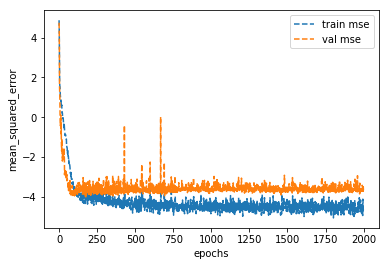

In [38]:
plt.plot(np.log(model.history.history['mean_squared_error']),label='train mse',ls='--')
plt.plot(np.log(model.history.history['val_mean_squared_error']),label='val mse',ls='--')
# plt.axis([0, 1000, 0, 0.5])
plt.legend()
plt.ylabel('mean_squared_error')
plt.xlabel('epochs')
plt.show()

## Random Forest

In [ ]:
rf = RandomForestRegressor(n_estimators=274,oob_score=True,max_features=8,max_depth=17,max_leaf_nodes=167)
rf.fit(train_x,log_train_y)
pred_y = rf.predict(test)
pred_y = np.exp(pred_y)-1
print(pred_y)

In [39]:
rf = RandomForestRegressor(n_estimators=704,oob_score=False,max_features='sqrt',max_depth=17,max_leaf_nodes=167)
rf.fit(train_x_reduced,log_train_y)
pred_y = rf.predict(test_reduced)
pred_y = np.exp(pred_y)-1
print(pred_y)

[127311.55440275 152189.90315663 184538.03256839 ... 167364.1148623
 123939.51920016 236033.91279129]


## Xgboost

In [ ]:
#Fitting XGB regressor 
xgbm = xgb.XGBRegressor(n_estimators=480,learning_rate=0.066,colsample_bylevel=0.57,colsample_bytree=0.46,n_jobs=-1)
xgbm.fit(train_x_reduced,train_y)
pred_y = xgbm.predict(test_reduced)
print(pred_y)

In [40]:
#Fitting XGB regressor 
xgbm = xgb.XGBRegressor(n_estimators=972,learning_rate=0.051,colsample_bylevel=0.778,colsample_bytree=0.064,n_jobs=-1)
xgbm.fit(train_x_reduced,log_train_y)
pred_y = xgbm.predict(test_reduced)
pred_y = np.exp(pred_y)+1
print(pred_y)

[125057.484 158605.31  191411.23  ... 167076.69  125434.086 220664.19 ]


## GradientBoosting

In [42]:
gbm = GradientBoostingRegressor(n_estimators=750,learning_rate=0.07,max_features=16,max_depth=5)
gbm.fit(train_x_reduced,train_y)
pred_y = gbm.predict(test_reduced)
print(pred_y)

[123286.62253313 172572.64705305 199763.47583914 ... 137302.54867924
 119645.33784178 223839.47955609]


## Summition

In [ ]:
summit=pd.DataFrame()
summit['Id']=range(1461,2920)
summit['SalePrice']=pred_y
summit.to_csv('D:/summit.csv',index=False)

## SearchCV

In [ ]:
rf = RandomForestRegressor(n_estimators=274,oob_score=True,max_features=8,max_depth=17,max_leaf_nodes=167)
param = {'n_estimators':range(695,711),'max_features':range(17,23)}
gsearch = GridSearchCV(rf,param,cv=3,scoring='neg_mean_squared_error',n_jobs=-1)
gsearch.fit(train_x_reduced,log_train_y)
print(gsearch.best_params_)

In [ ]:
xgbm = xgb.XGBRegressor(n_estimators=972,learning_rate=0.051,colsample_bylevel=0.778,colsample_bytree=0.064)
param = {'colsample_bylevel':[i/1000 for i in range(770,791)],'colsample_bytree':[i/1000 for i in range(60,71)]}
gsearch = GridSearchCV(xgbm,param,cv=10,scoring='neg_mean_squared_error',n_jobs=-1,return_train_score=True)
gsearch.fit(train_x_reduced,log_train_y)
print(gsearch.best_params_)

In [ ]:
# gbm = GradientBoostingRegressor(n_estimators=750,learning_rate=0.07,max_features=16,max_depth=5)
# param = {'max_depth':range(2,15)}
# gsearch = GridSearchCV(gbm,param,cv=10,scoring='neg_mean_squared_error',n_jobs=-1)
# gsearch.fit(train_x_reduced,train_y)
# print(gsearch.best_params_)